DSC530: Week 10\
10.2 Exercise\
Marty Hoehler\
5-19-24

# Exercise 12-1

First, we'll download data and import libraries as outlined in the text.

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [2]:
import numpy as np
import pandas as pd
import random

import thinkstats2
import thinkplot

##### Download Data
Download the .csv as "transactions."

In [3]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/mj-clean.csv")
transactions = pd.read_csv("mj-clean.csv", parse_dates=[5])

##### Formulas: GroupByDay() and GroupByQualityAndDay()
From the text, we use two formulas:
- first, to pull the "date" and "ppg" field from the table, and group by "date".  
-- It makes a fractional "date" field for a decimal value of years since the start date.
- second, to divide the grouped data frame by quality

In [4]:
def GroupByDay(transactions, func=np.mean):
    """Groups transactions by day and compute the daily mean ppg.

    transactions: DataFrame of transactions

    returns: DataFrame of daily prices
    """
    grouped = transactions[["date", "ppg"]].groupby("date")
    daily = grouped.aggregate(func)

    daily["date"] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, "Y")
    daily["years"] = (daily.date - start) / one_year

    return daily

In [5]:
def GroupByQualityAndDay(transactions):
    """Divides transactions by quality and computes mean daily price.

    transaction: DataFrame of transactions

    returns: map from quality to time series of ppg
    """
    groups = transactions.groupby("quality")
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)

    return dailies

In [6]:
dailies = GroupByQualityAndDay(transactions)
dailies

{'high':                   ppg       date     years
 date                                      
 2010-09-02  13.384186 2010-09-02  0.000000
 2010-09-03  14.459588 2010-09-03  0.002738
 2010-09-04  14.923333 2010-09-04  0.005476
 2010-09-05  16.667500 2010-09-05  0.008214
 2010-09-06  15.537500 2010-09-06  0.010952
 ...               ...        ...       ...
 2014-05-09  11.468298 2014-05-09  3.682485
 2014-05-10  10.532326 2014-05-10  3.685223
 2014-05-11  11.518750 2014-05-11  3.687961
 2014-05-12  10.578293 2014-05-12  3.690699
 2014-05-13   9.604615 2014-05-13  3.693437
 
 [1241 rows x 3 columns],
 'low':                   ppg       date     years
 date                                      
 2010-09-02   4.943750 2010-09-02  0.000000
 2010-09-03   3.984138 2010-09-03  0.002738
 2010-09-04   3.530000 2010-09-04  0.005476
 2010-09-10   4.240000 2010-09-10  0.021903
 2010-09-14   6.066118 2010-09-14  0.032855
 ...               ...        ...       ...
 2014-05-09  14.700000 2014-05-09

##### Quadratic Model
For this assignment, we would like to create a quadratic model.  To do this, we need to create a squared term.
 - updating the "RunLinearModel()" function into a "RunQuadraticModel()" funcion by adding 'years2' (pg 133 in text).

In [7]:
import statsmodels.formula.api as smf


def RunQuadraticModel(daily):
    daily['years2'] = daily.years**2
    model = smf.ols("ppg ~ years + years2", data=daily)
    results = model.fit()
    return model, results




Next, we'll cut the dictionary down to the "high" values and run our quadratic formula on it.

In [8]:

quaddata = dailies["high"]
model, results = RunQuadraticModel(quaddata)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     517.5
Date:                Sun, 19 May 2024   Prob (F-statistic):          4.57e-164
Time:                        12:17:05   Log-Likelihood:                -1497.4
No. Observations:                1241   AIC:                             3001.
Df Residuals:                    1238   BIC:                             3016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6980      0.067    205.757      0.000      13.567      13.829
years         -1.1171      0.084    -13.326      0.000      -1.282      -0.953
years2         0.1132      0.022      5.060      0.000       0.069       0.157
==============================================================================
Omnibus:                       49.112   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.885
Skew:                           0.199   Prob(JB):                     1.86e-25
Kurtosis:                       4.430   Cond. No.                         27.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R-squared for this quadratic model (0.455) is an improvement over the R-squared for the linear model (0.444), and the Adj. R-Squared does not fall off very much (0.454), indicating that this model is slightly more predictive than the linear model, and the added variable years<sup>2</sup> does not detract much from that improvement.

##### Plotting the Model
Next, we'll adjust the "PlotLinearModel()" function from the test to plot our quadratic model instead.
- "PlotFittedValues()" needs no changes from the author's text.
- We'll add our "RunQuaraticModel()" formula into the "PlotLinearModel()" formula and call it "Plot Quadratic Model".

In [9]:
def PlotFittedValues(model, results, label=""):
    """Plots original data and fitted values.

    model: StatsModel model object
    results: StatsModel results object
    """
    years = model.exog[:, 1]
    values = model.endog
    thinkplot.Scatter(years, values, s=15, label=label)
    thinkplot.Plot(years, results.fittedvalues, label="model", color="#ff7f00")
    
def PlotQuadraticModel(daily, name):
    """Plots a quadratic fit to a sequence of prices, and the residuals.

    daily: DataFrame of daily prices
    name: string
    """
    model, results = RunQuadraticModel(daily)
    PlotFittedValues(model, results, label=name)
    thinkplot.Config(
        title="Fitted values",
        xlabel="Years",
        xlim=[-0.1, 3.8],
        ylabel="Price per gram ($)",
    )

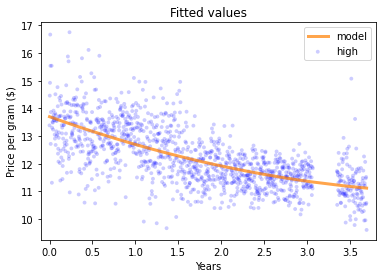

In [10]:
PlotQuadraticModel(quaddata, "high")

##### Quadratic Predictions

Using the formulas outlined in the book, and adjusting them to take our quadratic model.

In [11]:
def PlotPredictions(daily, years, iters=101, percent=90, func=RunQuadraticModel):
    """Plots predictions.

    daily: DataFrame of daily prices
    years: sequence of times (in years) to make predictions for
    iters: number of simulations
    percent: what percentile range to show
    func: function that fits a model to the data
    """
    result_seq = SimulateResults(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100 - p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.3, color="gray")

    predict_seq = GeneratePredictions(result_seq, years, add_resid=False)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.5, color="gray")

In [12]:
def GeneratePredictions(result_seq, years, add_resid=False):
    """Generates an array of predicted values from a list of model results.

    When add_resid is False, predictions represent sampling error only.

    When add_resid is True, they also include residual error (which is
    more relevant to prediction).

    result_seq: list of model results
    years: sequence of times (in years) to make predictions for
    add_resid: boolean, whether to add in resampled residuals

    returns: sequence of predictions
    """
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pd.DataFrame(d)

    predict_seq = []
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += thinkstats2.Resample(fake_results.resid, n)
        predict_seq.append(predict)

    return predict_seq

In [13]:
def SimulateResults(daily, iters=101, func=RunQuadraticModel):
    """Run simulations based on resampling residuals.

    daily: DataFrame of daily prices
    iters: number of simulations
    func: function that fits a model to the data

    returns: list of result objects
    """
    _, results = func(daily)
    fake = daily.copy()

    result_seq = []
    for _ in range(iters):
        fake.ppg = results.fittedvalues + thinkstats2.Resample(results.resid)
        _, fake_results = func(fake)
        result_seq.append(fake_results)

    return result_seq

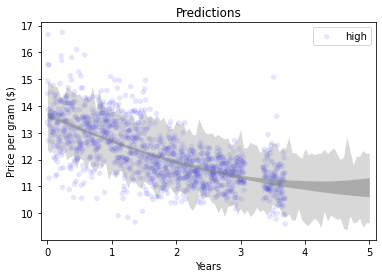

In [14]:
years = np.linspace(0, 5, 101)
thinkplot.Scatter(quaddata.years, quaddata.ppg, alpha=0.1, label="high")
PlotPredictions(quaddata, years)
xlim = years[0] - 0.1, years[-1] + 0.1
thinkplot.Config(
    title="Predictions", xlabel="Years", xlim=xlim, ylabel="Price per gram ($)"
)

Because of the quadratic model, we are now seeing the possibility of an increase in price coming in the future.  The linear model showed predictions with a downward slope.  These predictions don't account for possible changes in the environment.  They're based on what has occured in the past. The book rightly points out that changes in laws could change prices in ways that this model could not predict.

# Exercise 12-2

Building a class called "SerialCorrelationTest()" base on the tests from the "Hypothesis Test" section of the book (pg 102).  The author's solution was very instructive in showing how to do this.  I researched further into how these formulas work.  (See sources as listed.) \
    - TestStatistic() uses the SerialCorr() function provided to find the correlation coefficient.  We take the absolute value because we want to test the strength of the linear relationship.  We don't care about the direction of the slope of the line. \
    (Source: https://ellaudet.iq.harvard.edu/correlation) \
    - RunModel() uses reindex() and np.random.permutation() to take the data set and shuffle it into a random order.  This creates the null hypothesis set to compare against... a set where sequential values shouldn't have any relationship. \
    (Source: https://www.geeksforgeeks.org/reindexing-in-pandas-dataframe/)

In [15]:
class SerialCorrelationTest(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        series, lag = data
        test_stat = abs(SerialCorr(series, lag))
        return test_stat
    
    def RunModel(self):
        series,  lag = self.data
        permutation = series.reindex(np.random.permutation(series.index))
        return permutation, lag

We use the SerialCorr() formula from the text.  It brings the series into the 'xs' and uses the "shift()" function to assign the corresponding 'ys' the shifted value, and returns the correlation coefficient.

In [16]:
def SerialCorr(series, lag=1):
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = thinkstats2.Corr(xs, ys)
    return corr

Our "quaddata" set from above is set to give us the "high" quality group of prices per gram.  We'll feed that through our new formulas to test the original "quaddata" set of "ppg" against a randomized set, to see 


In [17]:
series = quaddata.ppg
test = SerialCorrelationTest((series,1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.4852293761947379 0.0


The serial correlation is 0.485, and the p-value is 0, which means that it is very unlikely that the strong correlation occurred by chance.

Next, we will test the correlation in the residuals of the linear model.  We haven't defined the linear model yet, so I will bring that in from our text.  We'll run the Linear model and find the residuals.  We'll use those residuals as the series for our hypothesis test.

In [18]:
def RunLinearModel(daily):
    model = smf.ols("ppg ~ years", data=daily)
    results = model.fit()
    return model, results

In [19]:
model, results = RunLinearModel(quaddata)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.07570473767506257 0.01


The strength of the correlation is less strong (.076), but the P-value of the null hypothesis remains low, so it is unlikely that the correlation occured by chance.

Finally, we'll use the quadratic model we created above to test the residuals for that.

In [20]:
model, results = RunQuadraticModel(quaddata)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.05607308161289917 0.046


Similar to the linear model, the correlation coefficient is low (0.056).  The P-value is slightly above 5% (.059), so there is a slight chance that it would be appropriate to accept the null hypothesis.  It depends on what threshold was set at the beginning of the analysis.